# Climate Signal Selector

The goal of this notebook is to develop a climate state selector that is generalized. Any variable can be requested. The result is a figure highlighting the overall change signal fo the variable. For example, temperature would show models that run hotter or colder. This allows a user to subset models for specific climate states they are most interested in. 

This work is built off of early work done by Will. Expanding to make this more generalized and allowing any variable to examined. 

Inputs:
* Domain, either as a county name or a custom shapefile
* Two variables to put on the x-axis and y-axis
* Time domain / GWL to use as the baseline and future period to compute change signal over
* Operation to use to aggregate over the time domain within each time period

## Make Selections

Before running this notebook, make the following selections for variables, domain, and GWLs. 

1. Select a timescale - this will impact which downscaling methods are available and which variables are availble.

In [4]:
timescale = "monthly" # options are hourly, daily or monthly

2. Select a variable - the code below displays which variables are available based on your timescale options

In [5]:
# import function 
from climakitae.explore.agnostic import (
  show_available_vars
)

In [6]:
# display variables available for this analysis 
# only showing dynamical because statistical has a smaller subset that is in the larger dynamical subset
# only difference is max/min RH is availble in statistical and not in dynamical 
show_available_vars("Dynamical",timescale)

['Air Temperature at 2m',
 'Precipitation (total)',
 'Relative humidity',
 'Dew point temperature',
 'Mean wind speed at 10m',
 'Maximum wind speed at 10m',
 'Surface Pressure',
 'Specific humidity at 2m',
 'Surface skin temperature',
 'Maximum air temperature at 2m',
 'Minimum air temperature at 2m',
 'Instantaneous downwelling longwave flux at bottom',
 'Instantaneous downwelling shortwave flux at bottom',
 'Shortwave flux at the surface',
 'Longwave flux at the surface',
 'Sensible heat flux at the surface',
 'Latent heat flux at the surface',
 'Ground heat flux',
 'Snowfall',
 'Liquid water path',
 'Evaporation',
 'Ice water path',
 'Maximum precipitation']

In [8]:
# make selection from list above
x_variable = "Air Temperature at 2m"
y_variable = "Precipitation (total)"

3. Select a GWLs - select a reference gwl and a future gwl 

In [9]:
# current options 0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 4.0
reference_gwl = "1.2"
future_gwl = "2.0"

4. Select Spatial Domain - provide a shapefile to clip data to

In [10]:
# edit path below and filename for shapefile to use
shapefile_filename = 'PajaroRiverWatershed.zip'
spatial_domian = "Pajaro" # name will appear in title

5. Select Resolution - select the the model resolution (3km, 9km, 45 km)

In [11]:
resolution = "3 km"

6. Select Change Signal - decide if you want absolute or fractional change

In [12]:
change_signal = "percentage" # options are percentage or absolute

## Import libraries & define functions

In [13]:
import climakitae as ck 
from climakitae.core.data_interface import (
    get_data_options, 
    get_subsetting_options, 
    get_data
)

import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [14]:
def clip_to_shapefile(da, shapefile):
    """
    Clip a DataArray to the boundaries of a shapefile.

    Parameters:
    - da: xarray DataArray to be clipped
    - shapefile: path to the shapefile

    Returns:
    - Clipped DataArray
    """
    # Read the shapefile using geopandas
    gdf = gpd.read_file(shapefile)

    # Ensure the DataArray has a CRS set
    #da.rio.write_crs("epsg:2228", inplace=True)

    # Clip the DataArray using the shapefile geometry
    clipped_da = da.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

    return clipped_da

## Pull Data

### Dynamical Downscaling (wrf)

In [15]:
# WRF downscaling
wrf_data_xy = [get_data(
        variable = GETVAR, 
        downscaling_method = "Dynamical", 
        resolution = resolution, 
        timescale = timescale, 
        # Modify your approach 
        approach = "Warming Level",
        warming_level= [float(reference_gwl), float(future_gwl)]
    ) for GETVAR in [x_variable, y_variable]]
# merge
wrf_data_xy = xr.merge([wrf_data_xy[0], wrf_data_xy[1]])

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Returned data array is large. Operations could take up to 5x longer than 1GB of data!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

WARNING FOR WARMING LEVELS APPROACH
-----------------------------------
There may be NaNs in your data for certain simulation/warming level combinations if the warming level is not reached for that particular simulation before the year 2100. 

This does not mean you have missing data, but rather a feature of how the data is combined in retrieval to return a single data object. 

If you want to remove these empty simulations, it is recommended to first subset the data object by each individual warming level and then dropping NaN values.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Returned data array is large. Operations could take up to 5x longer than 1GB of data!
!!!!!!!!!!!!!!!!!

In [16]:
# rename lat lon
wrf_data_xy=wrf_data_xy.rename({'x': 'longitude','y': 'latitude'})

### Statistical Downscaling (loca2)

In [17]:
# grab correct variable name for loca 2 
x_loca_variable = [x_variable]
y_loca_variable = [y_variable]
# temperature
if x_loca_variable[0] == "Air Temperature at 2m":
    x_loca_variable = ["Maximum air temperature at 2m", "Minimum air temperature at 2m"]
if y_loca_variable[0] == "Air Temperature at 2m":
    y_loca_variable = ["Maximum air temperature at 2m", "Minimum air temperature at 2m"]

# relative humidity
if x_loca_variable[0] == "Relative humidity":
    x_loca_variable = ["Minimum relative humidity", "Maximum relative humidity"]
if y_loca_variable[0] == "Relative humidity":
    y_loca_variable = ["Minimum relative humidity", "Maximum relative humidity"]

In [18]:
# statistical - loca2 downscaling xvariable
loca_data_x = [get_data(
        variable = GETVAR, 
        downscaling_method = "Statistical", 
        resolution = resolution, 
        timescale = timescale, 
        # Modify your approach 
        approach = "Warming Level",
        warming_level= [float(reference_gwl), float(future_gwl)]
    ) for GETVAR in x_loca_variable]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

WARNING FOR WARMING LEVELS APPROACH
-----------------------------------
There may be NaNs in your data for certain simulation/warming level combinations if the warming level is not reached for that particular simulation before the year 2100. 

This does not mean you have missing data, but rather a feature of how the data is combined in retrieval to return a single data object. 

If you want to remove these empty simulations, it is recommended to first subset the data object by each individual warming level and then dropping NaN values.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to

In [19]:
# statistical - loca2 downscaling yvariable
loca_data_y = [get_data(
        variable = GETVAR, 
        downscaling_method = "Statistical", 
        resolution = resolution, 
        timescale = timescale, 
        # Modify your approach 
        approach = "Warming Level",
        warming_level= [float(reference_gwl), float(future_gwl)]
    ) for GETVAR in y_loca_variable]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

WARNING FOR WARMING LEVELS APPROACH
-----------------------------------
There may be NaNs in your data for certain simulation/warming level combinations if the warming level is not reached for that particular simulation before the year 2100. 

This does not mean you have missing data, but rather a feature of how the data is combined in retrieval to return a single data object. 

If you want to remove these empty simulations, it is recommended to first subset the data object by each individual warming level and then dropping NaN values.


In [20]:
# if we need to average 
if loca_data_y[0] is not None and loca_data_x[0] is not None:
    # temperature
    if x_variable == "Air Temperature at 2m":
        loca_data_x = (loca_data_x[0] + loca_data_x[1]) / 2
        loca_data_x.name = "Air Temperature at 2m"
    if y_variable == "Air Temperature at 2m":
        loca_data_y= (loca_data_y[0] + loca_data_y[1]) / 2
        loca_data_y.name = "Air Temperature at 2m"
        
    # relative humidity
    if x_variable == "Relative humidity":
        loca_data_x = (loca_data_x[0] + loca_data_x[1]) / 2
        loca_data_x.name = "Relative humidity"
    if y_variable == "Relative humidity":
        loca_data_y = (loca_data_y[0] + loca_data_y[1]) / 2
        loca_data_y.name = "Relative humidity"

In [21]:
# unlist if needed
if type(loca_data_y) == list:
    loca_data_y = loca_data_y[0]
if type(loca_data_x) == list:
    loca_data_x = loca_data_x[0]

# now merge
# first check if there is valid loca data - requires that both x and y have valid data
if loca_data_y is None or loca_data_x is None:
    # set to wrf
    loca_data_xy = wrf_data_xy
    # replace with all NaNs
    loca_data_xy = loca_data_xy*np.nan
else:
    loca_data_xy = xr.merge([loca_data_x,loca_data_y])
    loca_data_xy=loca_data_xy.rename({'lon': 'longitude','lat': 'latitude'})

## Downsize Data  

In [22]:
# clip to shapefile
wrf_data_xy = clip_to_shapefile(wrf_data_xy, shapefile_filename)
loca_data_xy = clip_to_shapefile(loca_data_xy, shapefile_filename)

In [23]:
# average across domain
wrf_data_xy = wrf_data_xy.mean(['longitude','latitude'])
loca_data_xy = loca_data_xy.mean(['longitude','latitude'])

In [24]:
# average across time
wrf_data_xy = wrf_data_xy.mean(['time_delta'])
loca_data_xy = loca_data_xy.mean(['time_delta'])

## Import Data

In [25]:
loca_data_xy = loca_data_xy.compute()
wrf_data_xy = wrf_data_xy.compute()

In [26]:
# merge the data
merged_data = xr.merge([loca_data_xy, wrf_data_xy])

## Calculate Change Signal

In [27]:
# for both the loca and WRF data calculate the change signal in absolute terms
loca_delta_signal= loca_data_xy.sel(warming_level = float(future_gwl)) - loca_data_xy.sel(warming_level = float(reference_gwl))
wrf_delta_signal= wrf_data_xy.sel(warming_level = float(future_gwl)) - wrf_data_xy.sel(warming_level = float(reference_gwl))

In [28]:
# if percentage calculate signal
if change_signal == "percentage":
    loca_delta_signal = (loca_delta_signal / loca_data_xy.sel(warming_level = float(reference_gwl))) * 100
    wrf_delta_signal = (wrf_delta_signal / wrf_data_xy.sel(warming_level = float(reference_gwl))) * 100

In [29]:
# compute
loca_delta_signal = loca_delta_signal.compute()
wrf_delta_signal = wrf_delta_signal.compute()

## Plot Results (Yay!) 

In [30]:
# determine the simulation names
lsims = loca_delta_signal.simulation.values
wsims = wrf_delta_signal.simulation.values
sims = lsims.tolist() + wsims.tolist()
unique_models = list(set([s.split("_")[1] for s in sims]))

In [31]:
# create a pallette of colors
col_palette  = sns.color_palette("viridis", n_colors=len(unique_models))

In [32]:
# list of all possible markers
markers = [
    "o", "<","s", "^", "D", "X", "*", "P", "D", "h",">"
]

In [33]:
# set markers and colors
model_colors = dict(zip(unique_models, col_palette))
model_markers = dict(zip(unique_models, markers*4))

In [34]:
# set font size for plot
plt.rcParams.update({'font.size': 14})

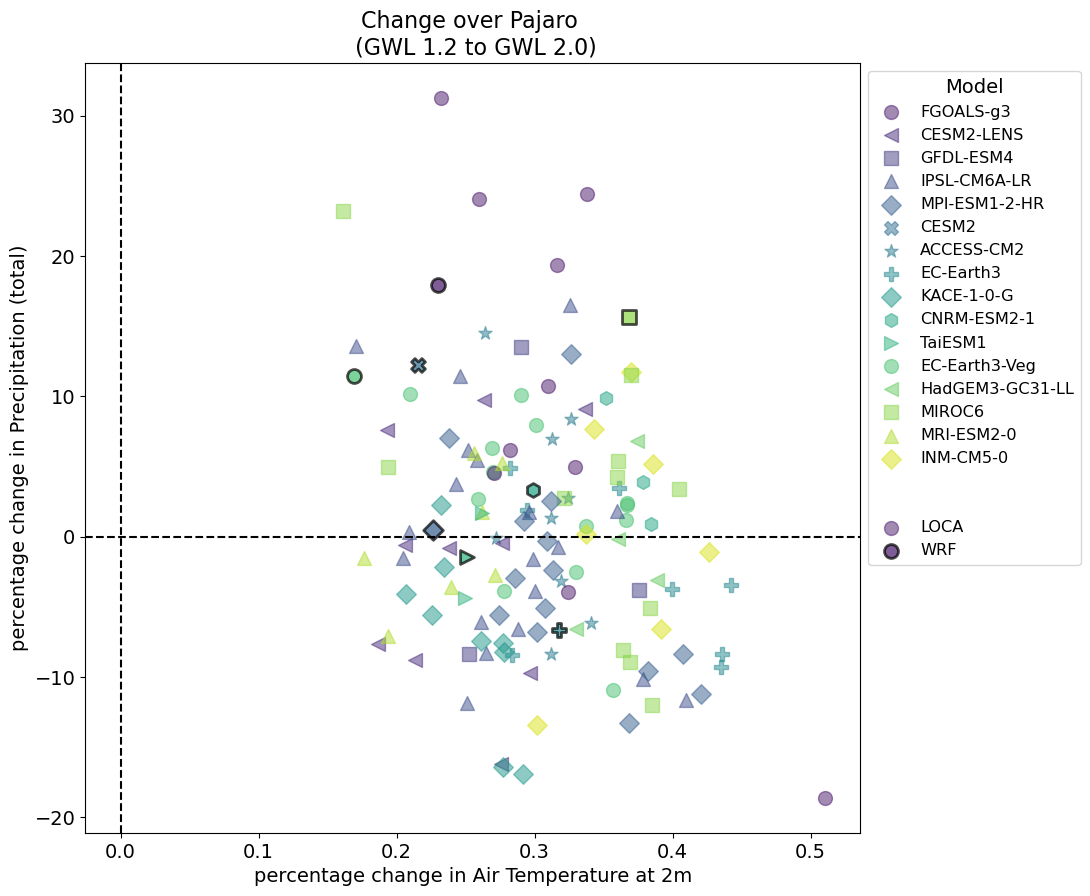

In [35]:
# create the scatterplot
# plot setup
figure = plt.figure(figsize=(10, 10))
ax = figure.add_subplot(111)
ax.set_title(f"Change over {spatial_domian} \n (GWL {reference_gwl} to GWL {future_gwl})", fontsize=16)
ax.set_xlabel(f"{change_signal} change in {x_variable}")
ax.set_ylabel(f"{change_signal} change in {y_variable}")

for i, loca_sim in enumerate(loca_delta_signal.simulation.values):
    model = loca_sim.split("_")[1]
    color = model_colors[model]
    marker = model_markers[model]
    # rotate through markers
    ax.scatter(loca_delta_signal[x_variable].sel(simulation=loca_sim), loca_delta_signal[y_variable].sel(simulation=loca_sim), color = color, label=None, marker=marker, s=100, alpha=0.5)

for i, wrf_sim in enumerate(wrf_delta_signal.simulation.values):
    model = wrf_sim.split("_")[1]
    color = model_colors[model]
    marker = model_markers[model]
    ax.scatter(wrf_delta_signal[x_variable].sel(simulation=wrf_sim), wrf_delta_signal[y_variable].sel(simulation=wrf_sim), color = color, label=None, linewidths=2, edgecolor='black', marker=marker, s=100, alpha=0.7)

for model in unique_models:
    ax.scatter([], [], color=model_colors[model], label=model, marker=model_markers[model], s=100, alpha=0.5)
ax.scatter([], [], color=model_colors[unique_models[0]], label='  ', marker=model_markers[unique_models[0]], s=100, alpha=0.0)
ax.scatter([], [], color=model_colors[unique_models[0]], label=' ', marker=model_markers[unique_models[0]], s=100, alpha=0.0)
ax.axvline(x=0, color='black', linestyle='--')
ax.axhline(y=0, color='black', linestyle='--')

ax.scatter([], [], color=model_colors[unique_models[0]], label='LOCA', marker=model_markers[unique_models[0]], s=100, alpha=0.5)
ax.scatter([], [], color=model_colors[unique_models[0]], label='WRF', marker=model_markers[unique_models[0]], linewidths=2, edgecolor='black', s=100, alpha=0.7)

ax.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

In [45]:
# Save the figure to a file
figure.savefig(f'climate_signal_{x_variable}_{y_variable}.jpeg'.replace(" ", "_"))